# Notebook

In [1]:
# installs- comment out if good

!git clone https://github.com/wtlu71/cnn-comp-med.git

import numpy as np
import os
from tqdm import tqdm
import sys
import os
import pandas as pd
import seaborn as sns

repo_path = '/content/cnn-comp-med'
# Add to Python path
sys.path.append(repo_path)
# imports
from my_scripts.test import potato
from my_scripts.my_models import SmallCNN, SmallMLP
from my_scripts.dataset_loading import H5Dataset
from my_scripts.utils import run_epoch

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader, Subset
import torchvision.models as models
from torchvision.models import resnet50
from torchvision import datasets, transforms

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
weights_folder = "weights"
dataset_folder = os.path.join(os.getcwd(),"data")
external_dataset_folder = "breast-histopathology-images-subset"

fatal: destination path 'cnn-comp-med' already exists and is not an empty directory.


In [2]:
!pip install -U gdown

In [3]:
os.makedirs(weights_folder,exist_ok=True)
os.makedirs(external_dataset_folder,exist_ok=True)
download = True # set true if need to download
if download:
  !gdown --folder --remaining-ok https://drive.google.com/drive/folders/1EnF-qAa2JMD66KRQCIs-xOUmWiXiDA11 -O weights #weights folder storing train,test,val stratified idx
  !gdown --id 1lAtil7jdHGi9MM6d3WbxALmYYWVC_2R5 -O breast-histopathology-images-subset.zip #external testing subset
  !unzip -q breast-histopathology-images-subset.zip

Retrieving folder contents
Retrieving folder 1TGWX-NN_KmssOnxQucKMhV_t_Fbxobsm .ipynb_checkpoints
Retrieving folder 18Lyiz4SQdaDn0Ot0oQj4lN9NKf5qkd_e resnet
Processing file 1Z72UXI0XmKiYEEQJDAyV3LFp15_mG4pM resnet.pth
Processing file 1HncVXpZ74ubG0dDDgOJ2mwZL8ANnMiCH efficientNet.pth
Processing file 19nhMhct1JG_61LIP5YLLEURSLT0i1Xkh LargeCNN_subset.pth
Processing file 1SXSm5-C9mwdvmPzfgOlcqj0UipK17PWg ResNet_subset.pth
Processing file 1XDoT88p-K5nU-gwBq-26c0OCOM9Nrzyp ResNet.pth
Processing file 14o0LoXRmt-YvXEE1fIqXUlvKmxoFtSxw SmallCNN_subset.pth
Processing file 1_CjNFjxdXJztdQAb6ASvm_mPQluqU_Jk SmallMLP_subset.pth
Processing file 1HkfPOp6pRIM6aYzYTyV7jDjRgueM5PjH test.idx.npy
Processing file 1j9CoCJtBHgbnvM4ZrT2mz4wqYQ341Hoz test.npy
Processing file 1QXXpAsAGwGknjcOl-j8-TjALetQObNdn train.idx.npy
Processing file 1Yl_L14-Q-tGEOEa0KOZwxOnGGulPxHtC train.npy
Processing file 1HLwctzyNbIAUcoIpwvh7RXNbA0f27S8V val.idx.npy
Processing file 1krzZg7q3pTGPbILC9U9nt4YCFblIRme_ val.npy
Retrieving

In [4]:
print(potato(2, 4))

6


Get train/val/test data from Zenodo:

In [5]:
os.makedirs(dataset_folder,exist_ok=True)
# !apt-get install -y wget2
if download:
  !apt-get install -y aria2

  # !aria2c -x 16 -s 16 -k 1M -c -j 1 "URL" -o output_filename
  #train
  !aria2c -x 16 -s 16 -k 1M -c -j 1 "https://zenodo.org/records/2546921/files/camelyonpatch_level_2_split_train_x.h5.gz?download=1" -o data/train_x.h5.gz
  !gunzip data/train_x.h5.gz

  !wget https://zenodo.org/records/2546921/files/camelyonpatch_level_2_split_train_y.h5.gz?download=1 -O data/train_y.h5.gz
  !gunzip data/train_y.h5.gz

  # val
  !aria2c -x 16 -s 16 -k 1M -c -j 1 "https://zenodo.org/records/2546921/files/camelyonpatch_level_2_split_valid_x.h5.gz?download=1" -o data/valid_x.h5.gz
  !gunzip data/valid_x.h5.gz

  !wget https://zenodo.org/records/2546921/files/camelyonpatch_level_2_split_valid_y.h5.gz?download=1 -O data/valid_y.h5.gz
  !gunzip data/valid_y.h5.gz

  # test
  !aria2c -x 16 -s 16 -k 1M -c -j 1 "https://zenodo.org/records/2546921/files/camelyonpatch_level_2_split_test_x.h5.gz?download=1" -o data/test_x.h5.gz
  !gunzip data/test_x.h5.gz

  !wget https://zenodo.org/records/2546921/files/camelyonpatch_level_2_split_test_y.h5.gz?download=1 -O data/test_y.h5.gz
  !gunzip data/test_y.h5.gz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libaria2-0 libc-ares2
The following NEW packages will be installed:
  aria2 libaria2-0 libc-ares2
0 upgraded, 3 newly installed, 0 to remove and 41 not upgraded.
Need to get 1,513 kB of archives.
After this operation, 5,441 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-ares2 amd64 1.18.1-1ubuntu0.22.04.3 [45.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libaria2-0 amd64 1.36.0-1 [1,086 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 aria2 amd64 1.36.0-1 [381 kB]
Fetched 1,513 kB in 2s (667 kB/s)
Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.18.1-1ubuntu0.22.04.3_amd64.deb ...
Unpacking libc-ares2:amd64 (1.18.1-1ubuntu

In [6]:
# full external dataset if needed
# !curl -L -o breast-histopathology-images.zip\
#   https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/breast-histopathology-images && unzip /content/breast-histopathology-images.zip

In [7]:
# define transforms

# is there a way to get this programmatically from the data or not worth it
IMG_SIZE = 96
BATCH_SIZE = 100
# Training transforms with augmentation
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test transforms (no augmentation)
eval_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

print("Data transforms defined")

Data transforms defined


In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

# dataset paths- Colab virtual session
train_img_h5_path = os.path.join(dataset_folder,"train_x.h5")
train_label_h5_path = os.path.join(dataset_folder,"train_y.h5")

val_img_h5_path = os.path.join(dataset_folder,"valid_x.h5")
val_label_h5_path = os.path.join(dataset_folder,"valid_y.h5")

test_img_h5_path = os.path.join(dataset_folder,"test_x.h5")
test_label_h5_path = os.path.join(dataset_folder,"test_y.h5")


train_subset_size = 50000 #keeping compute restraints in mind
eval_subset_size = 5000
pin_memory = torch.cuda.is_available()
use_precomputed_indices = True

train_dataset = H5Dataset(train_img_h5_path,train_label_h5_path,transform=train_transforms)
train_labels = np.array([label for _, label in train_dataset])

val_dataset = H5Dataset(val_img_h5_path,val_label_h5_path,transform=train_transforms)
val_labels = np.array([label for _, label in val_dataset])

test_dataset = H5Dataset(test_img_h5_path,test_label_h5_path,transform=train_transforms)
test_labels = np.array([label for _, label in test_dataset])

if use_precomputed_indices:
  train_idx = np.load(os.path.join(weights_folder,f"train.npy"))
  val_idx = np.load(os.path.join(weights_folder,f"val.npy"))
  test_idx = np.load(os.path.join(weights_folder,f"test.npy"))
  test_idx = np.load(os.path.join(weights_folder,f"test.npy"))
else:
  sss = StratifiedShuffleSplit(n_splits=1, train_size=train_subset_size, random_state=42)
  train_idx, _ = next(sss.split(np.zeros(len(train_labels)), train_labels))  # indices for stratified subset
  np.save(os.path.join(weights_folder,f"train.npy"),train_idx)

  sss = StratifiedShuffleSplit(n_splits=1, train_size=eval_subset_size, random_state=42)
  val_idx, _ = next(sss.split(np.zeros(len(val_labels)), val_labels))  # indices for stratified subset
  np.save(os.path.join(weights_folder,f"val.npy"),val_idx)

  sss = StratifiedShuffleSplit(n_splits=1, train_size=eval_subset_size, random_state=42)
  test_idx, _ = next(sss.split(np.zeros(len(test_labels)), test_labels))  # indices for stratified subset
  np.save(os.path.join(weights_folder,f"test.npy"),test_idx)

train_dataset = Subset(train_dataset, train_idx)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,pin_memory=pin_memory)

val_dataset = Subset(val_dataset, val_idx)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,pin_memory=pin_memory)

test_dataset = Subset(test_dataset, test_idx)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,pin_memory=pin_memory)

#external is already stratified
external_test_dataset = datasets.ImageFolder(external_dataset_folder,transform=eval_transforms)
external_test_loader = DataLoader(external_test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,pin_memory=pin_memory)

In [9]:
# import matplotlib.pyplot as plt
# from torchvision import transforms


# for images,targets in external_test_loader:
#   images,targets = images.to(device),targets.to(device)
#   n = len(images)
#   print(n)
#   idx = np.random.randint(0,n)
#   target = targets[idx].item()
#   while target != 1:
#     target = targets[idx].item()
#     print(target)
#     continue
#   plt.imshow(images[idx].permute(2,1,0))
#   class2name = {0: "Normal", 1: "Cancer"}
#   plt.title(f"Class is {class2name[int(target)]}")
#   break


In [10]:
import torch
import torch.nn as nn

# Define a Convolution Block:
def conv_block(in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2)
    )

class LargeCNN(nn.Module):
    """Small CNN with 3 convolutional blocks"""
    def __init__(self, in_channels=3, num_classes=2, channels=(16, 32, 64,128,128,256), dropout=0.2):
        super().__init__()
        c1, c2, c3,c4,c5,c6 = channels

        # convolutional feature extractor
        self.features = nn.Sequential(
            # TODO: Implement 3 Blocks
            conv_block(in_channels, c1),
            conv_block(c1, c2),
            conv_block(c2, c3),
            conv_block(c3, c4),
            conv_block(c4, c5),
            conv_block(c5, c6),
            nn.Dropout(dropout)
        )

        # global average pooling (nn.AdaptiveAvgPool2d) compresses the spatial dimensions to NxCx1x1
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        # TODO: Linear layer for classification
        self.classifier = nn.Linear(c6, num_classes)

    #  forward pass (how the input passes through the CNN layers)
    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        # flatten until dimension 1 so that NxCx1x1 becomes NxC- suitable for linear layer
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.classifier(x)
        return x

In [11]:
# define/load models
num_classes = 2
mlpmodel = SmallMLP(size=((IMG_SIZE,IMG_SIZE))).to(device)
smallcnnmodel = SmallCNN(channels=(32,64,128)).to(device)
largecnnmodel = LargeCNN(channels=(32,64,128,64,64,64)).to(device)

resnetmodel = resnet50(weights = models.ResNet50_Weights.IMAGENET1K_V2).to(device)
# resnetmodel = resnet50(weights = None).to(device)
resnetmodel.fc = nn.Linear(resnetmodel.fc.in_features, num_classes)
# wresnetmodel = models.wide_resnet50_2(pretrained=True).to(device)
# wresnetmodel.fc = nn.Linear(wresnetmodel.fc.in_features, num_classes)

modellist = [mlpmodel, smallcnnmodel, resnetmodel]
modeldict = {
    "SmallMLP": mlpmodel,
    "SmallCNN": smallcnnmodel,
    "LargeCNN": largecnnmodel,
    "ResNet": resnetmodel
}

# training hyperparameters
# can change learning rate or use scheduler
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 3e-4
# finetune with less epochs to avoid forgetting
EPOCHS = 1
PATIENCE = EPOCHS
# patience- number of epochs the model continues after no improvement in validation loss

# consider other loss functions https://neptune.ai/blog/pytorch-loss-functions
criterion = nn.CrossEntropyLoss()
# don't change adam, never change dude

# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 243MB/s]


In [12]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()


Training SmallMLP...

Starting training...



100%|██████████| 1/1 [00:41<00:00, 41.37s/it]

Epoch 01: train_loss=0.9221 val_loss=0.6958 val_acc=0.516 val_auc=0.516

Restored best model (val_auc=0.5160)


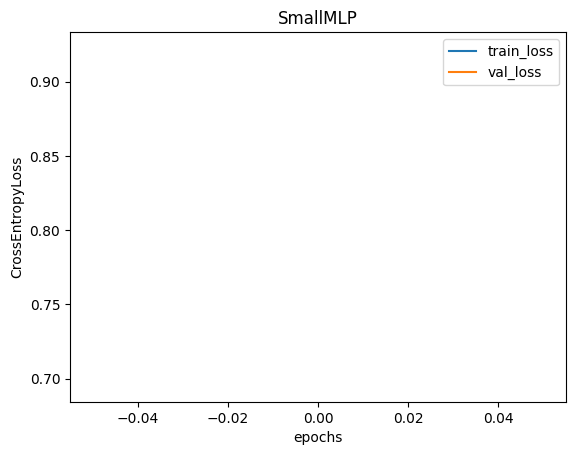

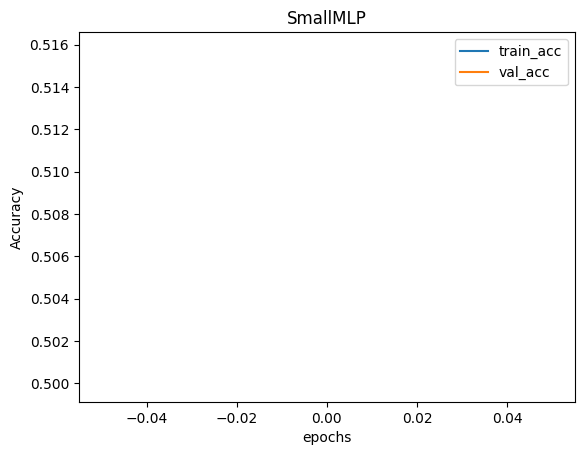

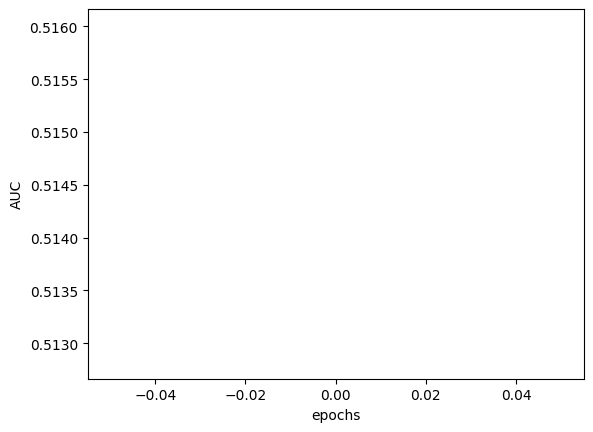

Training SmallCNN...

Starting training...



100%|██████████| 1/1 [00:42<00:00, 42.18s/it]

Epoch 01: train_loss=0.6105 val_loss=0.7145 val_acc=0.707 val_auc=0.868

Restored best model (val_auc=0.8680)


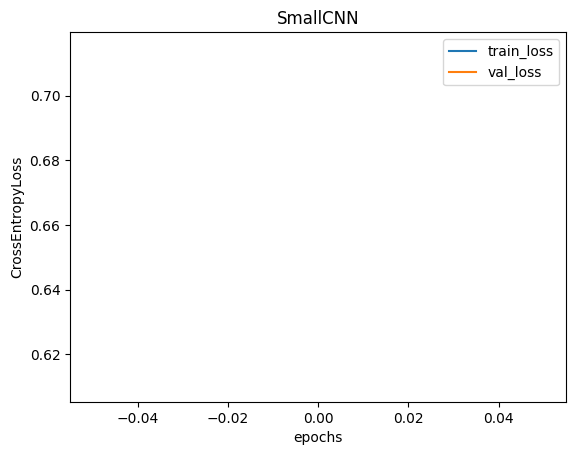

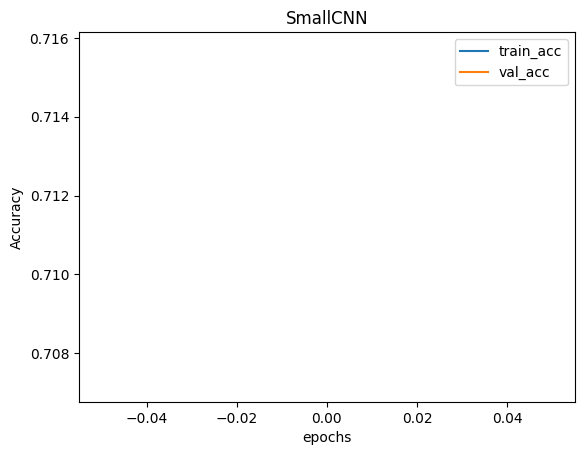

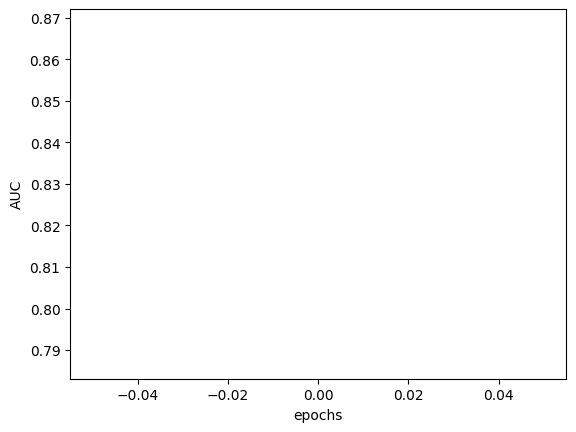

Training LargeCNN...

Starting training...



100%|██████████| 1/1 [00:40<00:00, 40.63s/it]

Epoch 01: train_loss=0.5126 val_loss=0.6099 val_acc=0.756 val_auc=0.819

Restored best model (val_auc=0.8193)


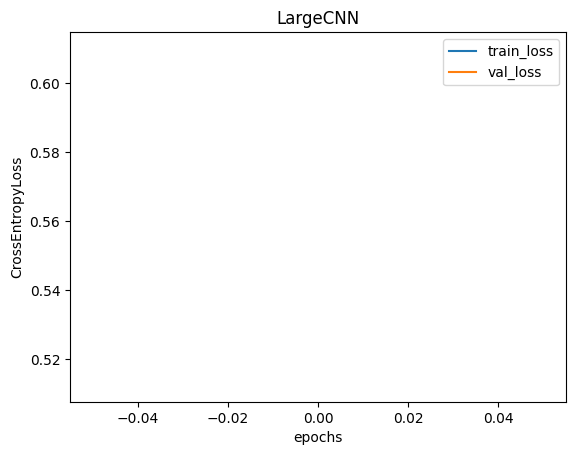

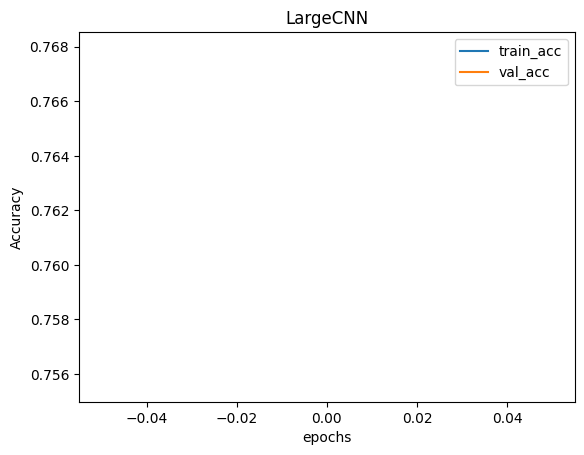

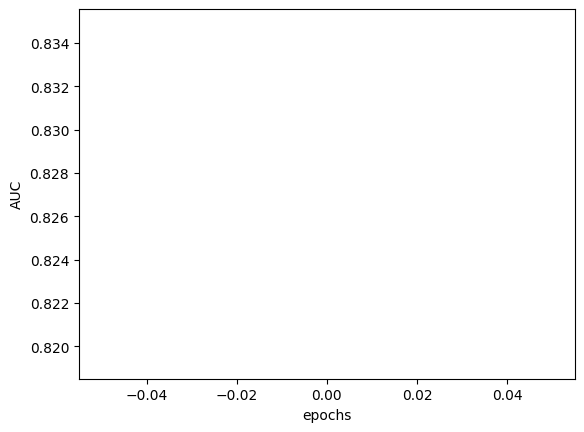

Training ResNet...

Starting training...



100%|██████████| 1/1 [00:41<00:00, 41.05s/it]

Epoch 01: train_loss=0.7392 val_loss=0.5525 val_acc=0.725 val_auc=0.816



Restored best model (val_auc=0.8160)


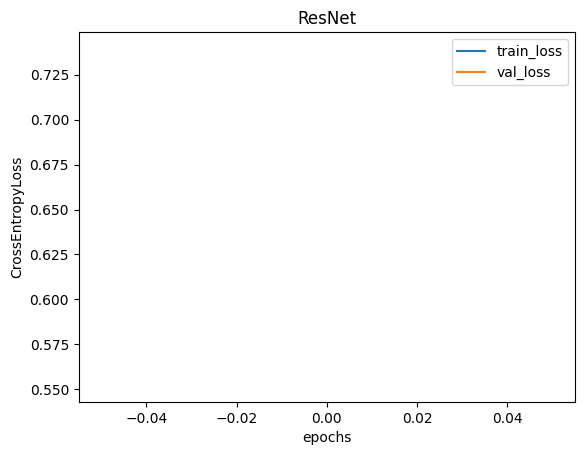

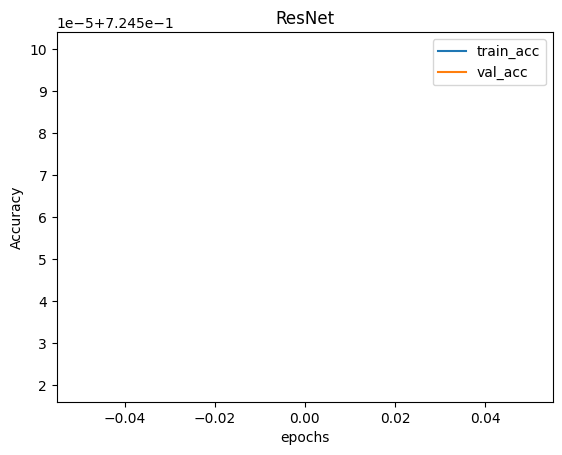

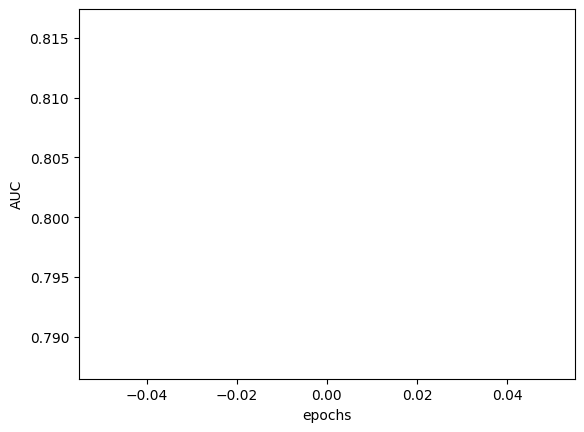

In [13]:

import matplotlib.pyplot as plt
historylist = []
stopepochs = []

for modelname, model in modeldict.items():
    print(f"Training {modelname}...")
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(),weight_decay=WEIGHT_DECAY, lr=LEARNING_RATE)

    # try to integrate into wandb instead of storing this so we can have a pretty dashboard?
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "train_auc": [],
        "val_acc": [],
        "val_auc": []
    }

    best_auc = -np.inf
    best_state = None
    bad_epochs = 0

    print("\nStarting training...\n")
    for epoch in tqdm(range(1, EPOCHS + 1)):
        tr_loss, tr_acc, _, _, tr_auc,_ = run_epoch(train_loader, model, criterion, optimizer=optimizer, train=True, device=device)
        va_loss, va_acc, va_sens, va_spec, va_auc,_ = run_epoch(val_loader, model, criterion, optimizer=None, train=False,device=device)

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_auc"].append(tr_auc)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)
        history["val_auc"].append(va_auc)

        print(f"Epoch {epoch:02d}: "
            f"train_loss={tr_loss:.4f} "
            f"val_loss={va_loss:.4f} "
            f"val_acc={va_acc:.3f} "
            f"val_auc={va_auc:.3f}")

        if va_auc > best_auc + 1e-4:
            best_auc = va_auc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= PATIENCE:
                print(f"\nEarly stopping at epoch {epoch}")
                break

    # Restore best model
    if best_state is not None:
        weights_path = os.path.join(weights_folder,f"{modelname}_subset.pth")
        torch.save(best_state,weights_path)
        model.load_state_dict(best_state)
        print(f"\nRestored best model (val_auc={best_auc:.4f})")


    plt.plot(history["train_loss"],label="train_loss")
    plt.plot(history["val_loss"],label="val_loss")
    plt.xlabel("epochs")
    plt.ylabel("CrossEntropyLoss")
    plt.legend()
    plt.title(modelname)
    plt.show()
    plt.plot(history["train_acc"],label="train_acc")
    plt.plot(history["val_acc"],label="val_acc")
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(modelname)
    plt.show()
    plt.plot(history["train_auc"],label="train_auc")
    plt.plot(history["val_auc"],label="val_auc")
    plt.xlabel("epochs")
    plt.ylabel("AUC")
    plt.show()

    historylist.append(history)
    stopepochs.append(epoch)

In [14]:
import json
history_path = os.path.join(weights_folder,"history.json")
with open(history_path,'w') as f:
  json.dump(historylist,f)

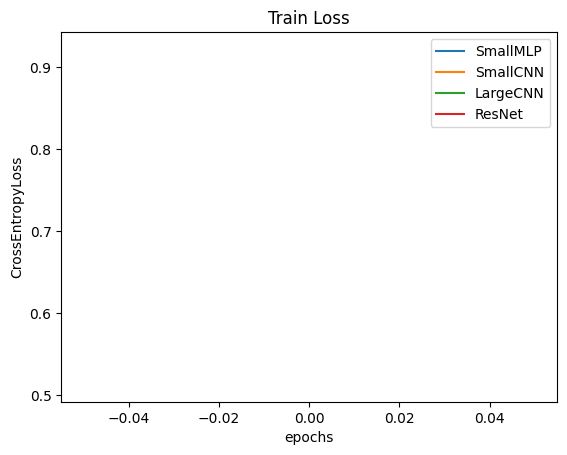

In [15]:

for i,history in enumerate(historylist):
  modelname = list(modeldict.keys())[i]
  plt.plot(history["train_loss"],label=modelname)
  plt.xlabel("epochs")
  plt.ylabel("CrossEntropyLoss")
  plt.legend()
  plt.title("Train Loss")
  # plt.show()

plt.show()



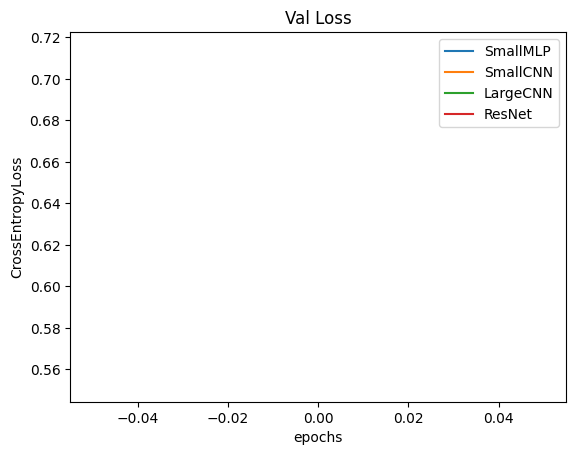

In [16]:
for i,history in enumerate(historylist):
  modelname = list(modeldict.keys())[i]
  plt.plot(history["val_loss"],label=modelname)
  plt.xlabel("epochs")
  plt.ylabel("CrossEntropyLoss")
  plt.legend()
  plt.title("Val Loss")
  # plt.show()

plt.show()



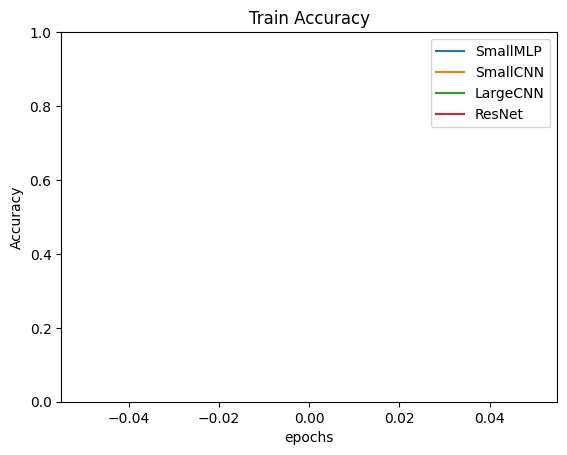

In [17]:
for i,history in enumerate(historylist):
  modelname = list(modeldict.keys())[i]
  plt.plot(history["train_acc"],label=modelname)
  plt.xlabel("epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.title("Train Accuracy")
  plt.ylim([0,1])
  # plt.show()

plt.show()


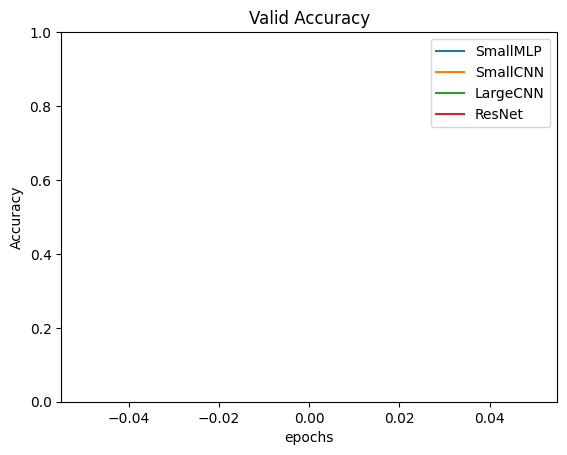

In [18]:
for i,history in enumerate(historylist):
  modelname = list(modeldict.keys())[i]
  plt.plot(history["val_acc"],label=modelname)
  plt.xlabel("epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.title("Valid Accuracy")
  plt.ylim([0,1])
  # plt.show()

plt.show()

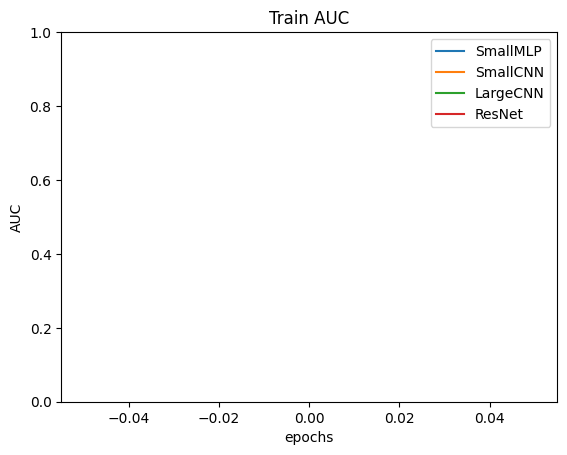

In [19]:
for i,history in enumerate(historylist):
  modelname = list(modeldict.keys())[i]
  plt.plot(history["train_auc"],label=modelname)
  plt.xlabel("epochs")
  plt.ylabel("AUC")
  plt.legend()
  plt.title("Train AUC")
  plt.ylim([0,1])
  # plt.show()

plt.show()

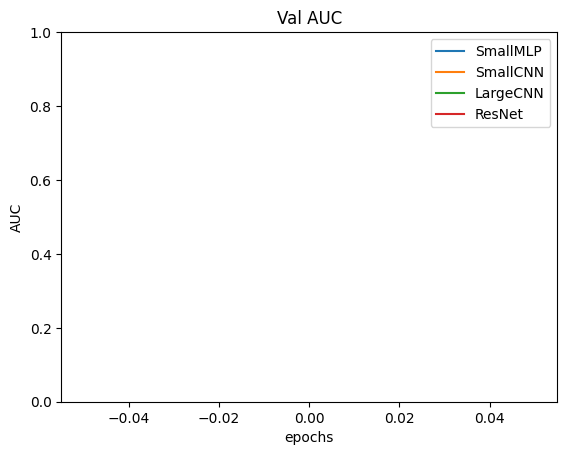

In [20]:
for i,history in enumerate(historylist):
  modelname = list(modeldict.keys())[i]
  plt.plot(history["val_auc"],label=modelname)
  plt.xlabel("epochs")
  plt.ylabel("AUC")
  plt.legend()
  plt.title("Val AUC")
  plt.ylim([0,1])
  # plt.show()

plt.show()


Evaluating SmallMLP...
Final Validation Performance:
  AUC:         0.5101
  Accuracy:    0.5104
  Sensitivity: 0.9852
  Specificity: 0.0360


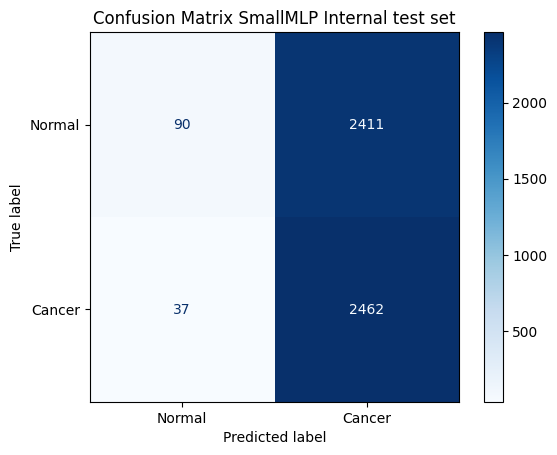


Evaluating SmallCNN...
Final Validation Performance:
  AUC:         0.8460
  Accuracy:    0.6638
  Sensitivity: 0.3958
  Specificity: 0.9316


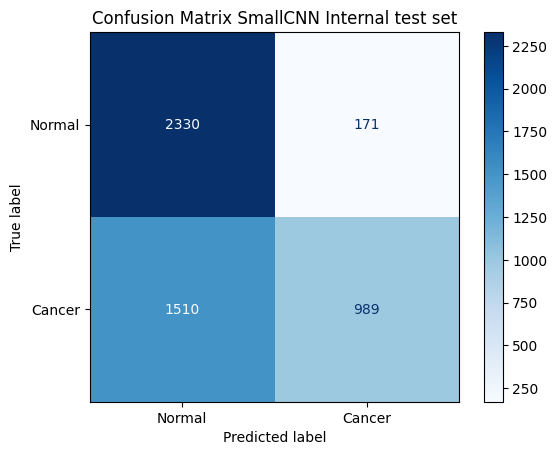


Evaluating LargeCNN...
Final Validation Performance:
  AUC:         0.8475
  Accuracy:    0.7706
  Sensitivity: 0.6787
  Specificity: 0.8625


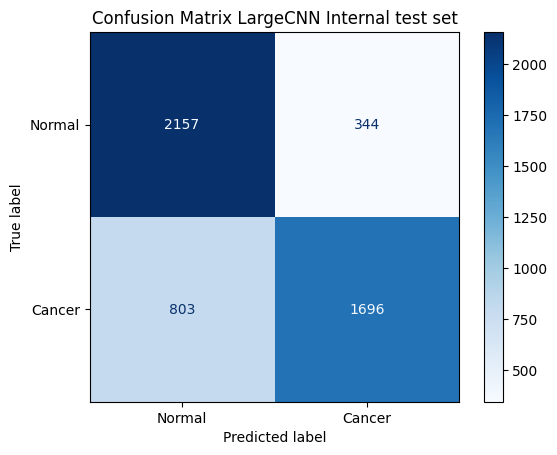


Evaluating ResNet...
Final Validation Performance:
  AUC:         0.7597
  Accuracy:    0.6644
  Sensitivity: 0.4962
  Specificity: 0.8325


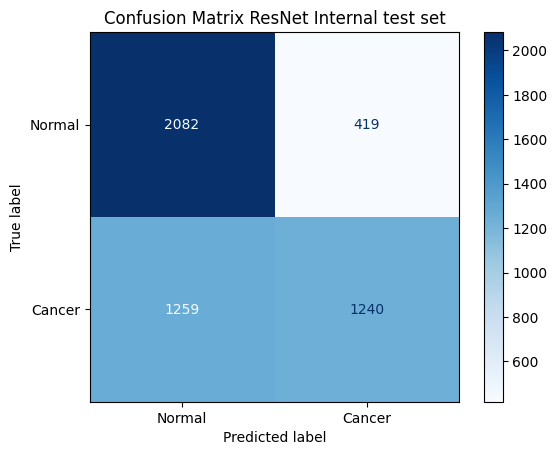

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# finally, evaluate on test set
# also do saliency

# model_attr_scores = []
# model_attr_channels = []
# model_preds = []
# model_targets = []

for modelname, model in modeldict.items():
  weights_path = os.path.join(weights_folder,f"{modelname}_subset.pth")
  model_state_dict = torch.load(weights_path)
  model.load_state_dict(model_state_dict)
  print(f"\nEvaluating {modelname}...")
  model.to(device)
  _, va_acc, va_sens, va_spec, va_auc,cm = run_epoch(test_loader, model, criterion, train=False, device=device)
  print(f"Final Validation Performance:")
  print(f"  AUC:         {va_auc:.4f}")
  print(f"  Accuracy:    {va_acc:.4f}")
  print(f"  Sensitivity: {va_sens:.4f}")
  print(f"  Specificity: {va_spec:.4f}")
  class_names = ["Normal", "Cancer"]
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=class_names)
  disp.plot(cmap='Blues', values_format='d')
  plt.title(f"Confusion Matrix {modelname} Internal test set")
  plt.show()

  # # now do saliency- eval again
  # print(f"Saliency for {modelname}")
  # model.eval()
  # saliency = Saliency(model)

  # attr_scores_list = []
  # attr_channels_list = []
  # pred_list = []
  # target_list = []

  # for images, targets in test_loader:
  #   images = images.to(device, non_blocking=True)
  #   targets = targets.to(device, non_blocking=True)
  #   images.requires_grad_()

  #   with torch.set_grad_enabled(True):
  #     logits = model(images)
  #     # loss = criterion(logits, targets)
  #     pred_classes = logits.argmax(dim=1)
  #     attr = saliency.attribute(images, target=pred_classes)
  #     # attr = attr.abs().cpu().detach().numpy()
  #     attr = attr.abs()
  #     attr_scores = attr.max(dim=1)[0]    # (batch_size, H, W)
  #     attr_channel = attr.argmax(dim=1)   # (batch_size, H, W)

  #   attr_scores_list.append(attr_scores)
  #   attr_channels_list.append(attr_channel)

  # all_attr_scores = torch.cat(attr_scores_list, dim=0)
  # all_attr_channels = torch.cat(attr_channels_list, dim=0)
  # model_attr_scores.append(all_attr_scores)
  # model_attr_channels.append(all_attr_channels)


In [23]:
# evaluating and saliency
!pip install torch torchvision captum pillow matplotlib
# !pip install captum

import torch
from torchvision import models, transforms
from captum.attr import Saliency
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

model_attr_scores = []
model_attr_channels = []
model_preds = []
model_targets = []

for modelname, model in modeldict.items():
  weights_path = os.path.join(weights_folder,f"{modelname}_subset.pth")
  model_state_dict = torch.load(weights_path)
  model.load_state_dict(model_state_dict)
  print(f"\nEvaluating saliency for {modelname}...")
  model.to(device)
  print(f"Saliency for {modelname}")
  model.eval()
  saliency = Saliency(model)

  attr_scores_list = []
  attr_channels_list = []
  pred_list = []
  target_list = []

  for images, targets in test_loader:
    images = images.to(device, non_blocking=True)
    targets = targets.to(device, non_blocking=True)
    images.requires_grad_()

    with torch.set_grad_enabled(True):
      logits = model(images)
      # loss = criterion(logits, targets)
      pred_classes = logits.argmax(dim=1)
      attr = saliency.attribute(images, target=pred_classes)
      # attr = attr.abs().cpu().detach().numpy()
      attr = attr.abs()
      attr_scores = attr.max(dim=1)[0]    # (batch_size, H, W)
      attr_channel = attr.argmax(dim=1)   # (batch_size, H, W)
    pred_list.append(pred_classes.cpu())
    target_list.append(targets.cpu())
    attr_scores_list.append(attr_scores)
    attr_channels_list.append(attr_channel)

  all_attr_scores = torch.cat(attr_scores_list, dim=0)
  all_attr_channels = torch.cat(attr_channels_list, dim=0)
  model_attr_scores.append(all_attr_scores)
  model_attr_channels.append(all_attr_channels)
  model_preds.append(torch.cat(pred_list, dim=0))
  model_targets.append(torch.cat(target_list, dim=0))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 127.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4


Evaluating saliency for SmallMLP...
Saliency for SmallMLP

Evaluating saliency for SmallCNN...
Saliency for SmallCNN

Evaluating saliency for LargeCNN...
Saliency for LargeCNN

Evaluating saliency for ResNet...
Saliency for ResNet


In [29]:
import torch.nn.functional as F

center_size = 32
pool_center_mask = torch.zeros((3, 3)).bool()
pool_center_mask[1, 1] = True

center_mask = torch.zeros((96, 96)).bool()
center_mask[32:64, 32:64] = True

all_sal_results = []

# assess the saliency score maps for each model
for i, (saliencies, imp_channels) in enumerate(zip(model_attr_scores, model_attr_channels)):
  # correct shape for avgpool
  sal = saliencies.unsqueeze(1)
  avgpool_sal = F.avg_pool2d(sal, kernel_size = center_size, stride = center_size).squeeze(1)
  center_avg = avgpool_sal[:, pool_center_mask].view(-1) # center
  outer_avg = avgpool_sal[:, ~pool_center_mask].view(len(avgpool_sal), 8).mean(dim=1) # outer
  center_focused = center_avg > outer_avg # vector for each image
  ratio = center_avg/outer_avg
  print(f"length of centeravg is {center_avg.shape}")
  print(f"length of outeravg is {outer_avg.shape}")
  print(f"length of centerfocused is {center_focused.shape}")
  print(f"length of ratio is {ratio.shape}")

  # now get most frequent channel in center and in outer
  imp_channels_center = imp_channels[:, center_mask]
  imp_channels_outer = imp_channels[:, ~center_mask]
  imp_channel_center = torch.mode(imp_channels_center.reshape(len(imp_channels), -1), dim=1).values
  imp_channel_outer = torch.mode(imp_channels_outer.reshape(len(imp_channels), -1), dim=1).values

  for j in range(len(center_avg)):
    row = {
        "modelname": list(modeldict.keys())[i],
        "image index": j,
        "center": center_avg[j].item(),
        "outer": outer_avg[j].item(),
        "center focused": center_focused[j].item(),
        "center ratio": ratio[j].item(),
        "important channel center": imp_channel_center[j].item(),
        "important channel outer": imp_channel_outer[j].item(),
    }
    all_sal_results.append(row)
    # sal_results = {
    #     "model name": [list(modeldict.keys())[i]]*len(center_avg.cpu()), # repeat model name for each image
    #     "image index":
    #     "center": center_avg.cpu(),
    #     "outer": outer_avg.cpu(),
    #     "center focused": center_focused.cpu()
    # }
    # all_sal_results.append(sal_results)

length of centeravg is torch.Size([5000])
length of outeravg is torch.Size([5000])
length of centerfocused is torch.Size([5000])
length of ratio is torch.Size([5000])
length of centeravg is torch.Size([5000])
length of outeravg is torch.Size([5000])
length of centerfocused is torch.Size([5000])
length of ratio is torch.Size([5000])
length of centeravg is torch.Size([5000])
length of outeravg is torch.Size([5000])
length of centerfocused is torch.Size([5000])
length of ratio is torch.Size([5000])
length of centeravg is torch.Size([5000])
length of outeravg is torch.Size([5000])
length of centerfocused is torch.Size([5000])
length of ratio is torch.Size([5000])


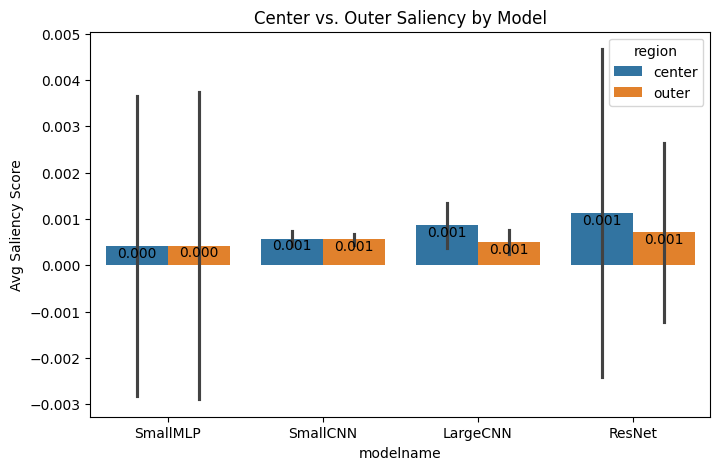

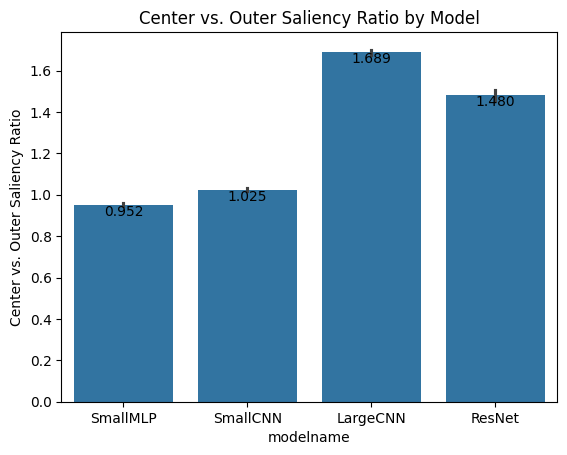

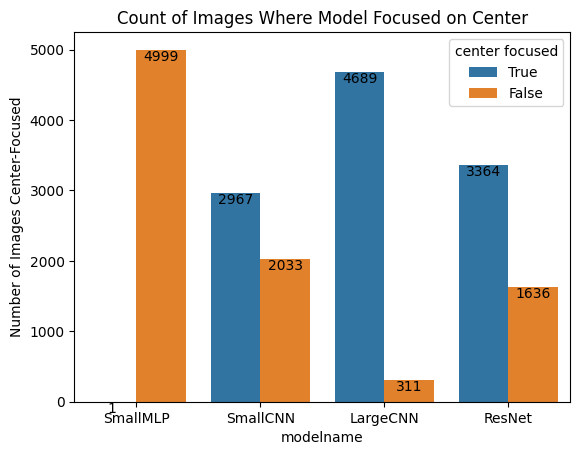

[0 2 1 3]
confusing SmallMLP
1 center-focused images
2461 true positives
94 true negatives
2407 false positives
38 false negatives
confusing SmallCNN
2967 center-focused images
1006 true positives
2333 true negatives
168 false positives
1493 false negatives
confusing LargeCNN
4689 center-focused images
1699 true positives
2153 true negatives
348 false positives
800 false negatives
confusing ResNet
3364 center-focused images
1228 true positives
2091 true negatives
410 false positives
1271 false negatives


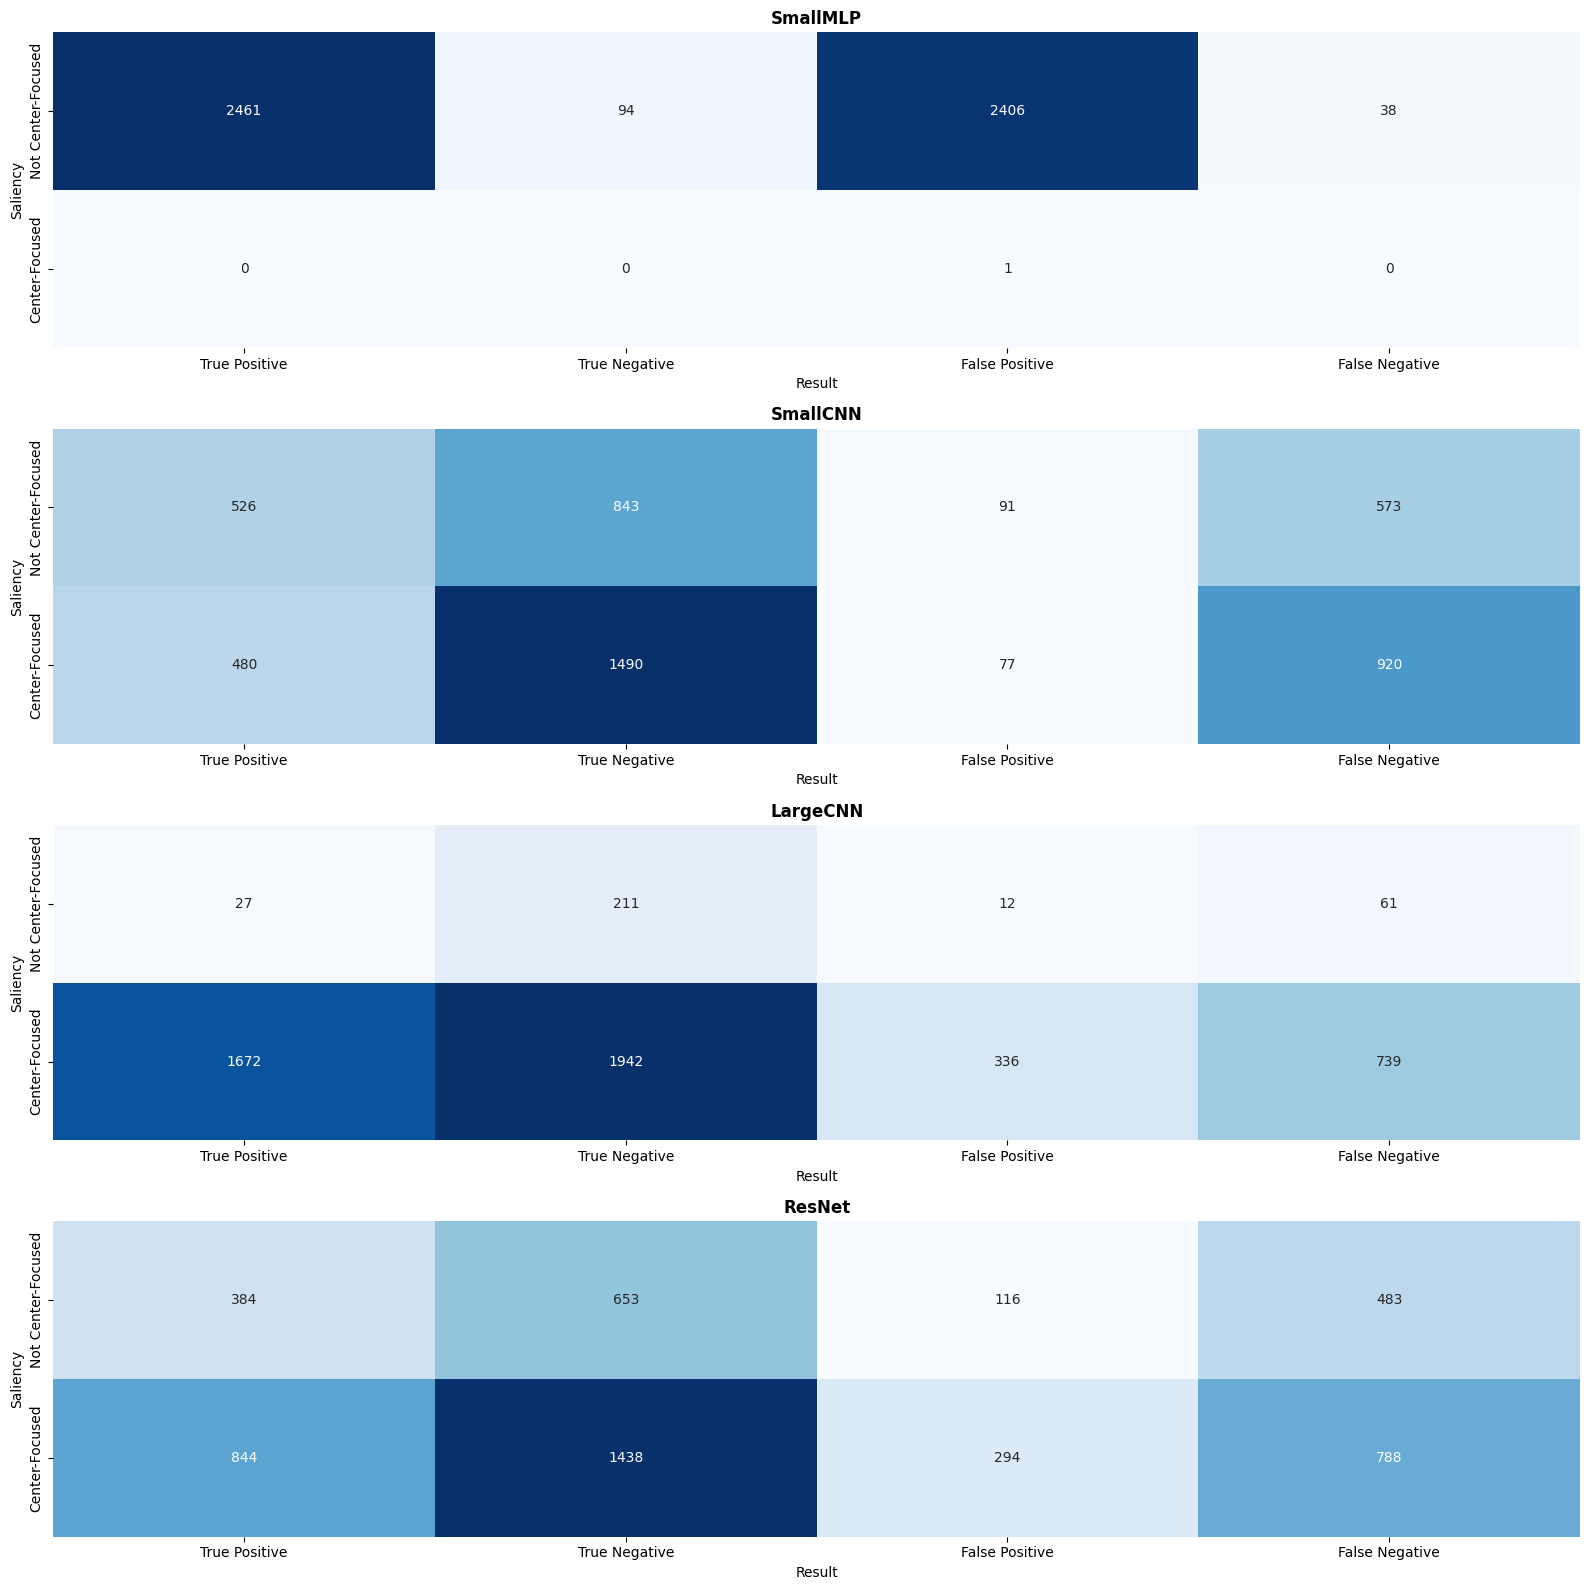

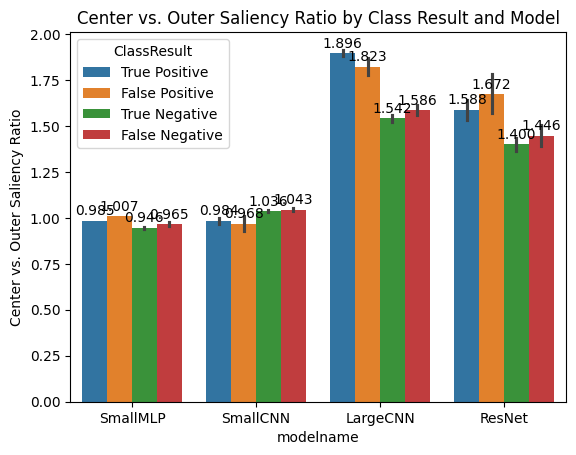

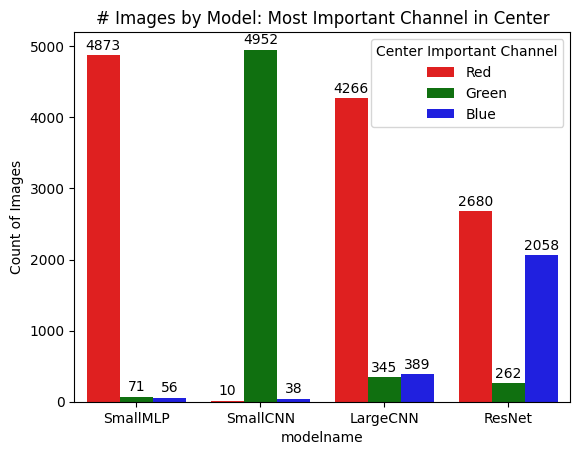

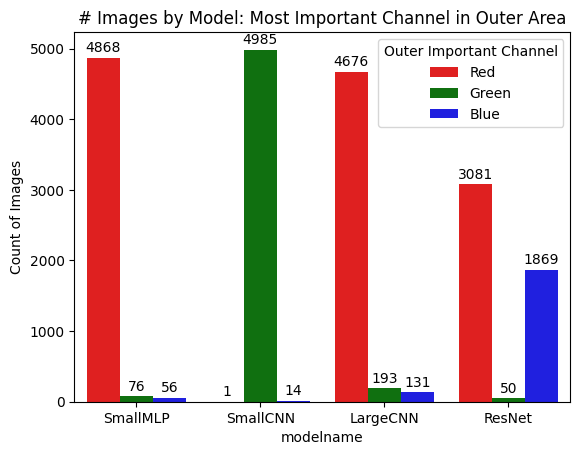

In [46]:
# bar plot- four groups two bars each- for each model, avg. center score vs. avg outer score
sal_df = pd.DataFrame(all_sal_results)
# melt the center and outer columns together
sal_melt_df = sal_df.melt(id_vars=["modelname", "image index", "center focused"], value_vars=["center", "outer"], value_name="saliency", var_name="region")
plt.figure(figsize=(8, 5))
p = sns.barplot(data=sal_melt_df, x="modelname", y="saliency", hue="region", errorbar="sd")
p.set(ylabel="Avg Saliency Score", title="Center vs. Outer Saliency by Model")
# p.tick_params(axis='x', rotation=30)
for container in p.containers:
  p.bar_label(container, fmt='%.3f', padding=-10)
plt.show()

# plot center vs. outer focus ratio for each model
p = sns.barplot(data=sal_df, x="modelname", y="center ratio")
p.set(ylabel="Center vs. Outer Saliency Ratio", title="Center vs. Outer Saliency Ratio by Model")
# p.tick_params(axis='x', rotation=30)
for container in p.containers:
  p.bar_label(container, fmt='%.3f', padding=-10)
plt.show()

# count how many images were center-focused vs. not
hue_order = [True, False]
p = sns.countplot(data=sal_df, x="modelname", hue="center focused", hue_order=hue_order)
p.set(ylabel="Number of Images Center-Focused", title="Count of Images Where Model Focused on Center")
# p.tick_params(axis='x', rotation=30)
for container in p.containers:
  p.bar_label(container, padding=-10)
plt.show()

# confusion matrix- 2x4- center-focused or not on one axis, TP, TN, FP, FN on the other
sal_df["Pred Class"] = torch.cat(model_preds, dim=0).cpu().numpy()
sal_df["Target Class"] = torch.cat(model_targets, dim=0).cpu().numpy()

sal_df["Class Result"] = -1

sal_df.loc[(sal_df["Pred Class"] == 1) & (sal_df["Target Class"] == 1), "Class Result"] = 0 # TP
sal_df.loc[(sal_df["Pred Class"] == 0) & (sal_df["Target Class"] == 0), "Class Result"] = 1 # TN
sal_df.loc[(sal_df["Pred Class"] == 1) & (sal_df["Target Class"] == 0), "Class Result"] = 2 # FP
sal_df.loc[(sal_df["Pred Class"] == 0) & (sal_df["Target Class"] == 1), "Class Result"] = 3 # FN

# check to make sure there's only 0, 1, 2, 3 and no -1 in "Class Result"
print(sal_df["Class Result"].unique())

# convert center focused to bool
sal_df["Center-Focused?"] = sal_df["center focused"].astype(int)

fig, axes = plt.subplots(4, 1, figsize=(16, 16))

# still a little unsure of the ordering in confusion matrix here
for ax, modelname in zip(axes, modeldict.keys()):
  print("confusing", modelname)
  model_df = sal_df[sal_df["modelname"] == modelname]
  # sanity check
  print(f"{model_df['Center-Focused?'].sum()} center-focused images")
  print(f"{(model_df['Class Result'] == 0).sum()} true positives")
  print(f"{(model_df["Class Result"] == 1).sum()} true negatives")
  print(f"{(model_df['Class Result'] == 2).sum()} false positives")
  print(f"{(model_df['Class Result'] == 3).sum()} false negatives")
  cm = confusion_matrix(model_df["Center-Focused?"], model_df["Class Result"])
  # plot heatmap
  s = sns.heatmap(
    cm[:2], annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False,
    xticklabels=["True Positive", "True Negative", "False Positive", "False Negative"],
    yticklabels=["Not Center-Focused", "Center-Focused"]
  )
  ax.set_title(f"{modelname}", fontsize=12, fontweight="bold")
  ax.set_xlabel("Result", fontsize=10)
  ax.set_ylabel("Saliency", fontsize=10)
plt.tight_layout() # adjust spacing
plt.show()

# plot saliency ratio by class result and model
# make a new column where the class result labels are strings
sal_df["ClassResult"] = sal_df["Class Result"].map({
    0: "True Positive",
    1: "True Negative",
    2: "False Positive",
    3: "False Negative"
})
hue_order = ["True Positive", "False Positive", "True Negative", "False Negative"]
# bar plot- ratio in TP, TN, FP, FN for each mode
p = sns.barplot(data=sal_df, x="modelname", y="center ratio", hue="ClassResult", hue_order=hue_order)
p.set(ylabel="Center vs. Outer Saliency Ratio", title="Center vs. Outer Saliency Ratio by Class Result and Model")
# p.tick_params(axis='x', rotation=30)
for container in p.containers:
  p.bar_label(container, fmt='%.3f', padding=2)
plt.show()

# make new columns where the channel index is the color name
sal_df["Center Important Channel"] = sal_df["important channel center"].map({
    0: "Red",
    1: "Green",
    2: "Blue",
})
sal_df["Outer Important Channel"] = sal_df["important channel outer"].map({
    0: "Red",
    1: "Green",
    2: "Blue",
})
hue_order = ["Red", "Green", "Blue"]
palette = ["red", "green", "blue"]
# plot important channel center by model
p = sns.countplot(data=sal_df, x="modelname", hue="Center Important Channel", hue_order=hue_order, palette=palette)
p.set(ylabel="Count of Images", title="# Images by Model: Most Important Channel in Center")
# p.tick_params(axis='x', rotation=30)
for container in p.containers:
  p.bar_label(container, padding=2)
plt.show()

# plot important channel outer by model
p = sns.countplot(data=sal_df, x="modelname", hue="Outer Important Channel", hue_order=hue_order, palette=palette)
p.set(ylabel="Count of Images", title="# Images by Model: Most Important Channel in Outer Area")
# p.tick_params(axis='x', rotation=30)
for container in p.containers:
  p.bar_label(container, padding=2)
plt.show()


In [ ]:
A!curl -L -o breast-histopathology-images.zip\
  https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/breast-histopathology-images && !unzip breast-histopathology-images.zip

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


for modelname, model in modeldict.items():
    weights_path = os.path.join(weights_folder,f"{modelname}_subset.pth")
    model_state_dict = torch.load(weights_path)
    model.load_state_dict(model_state_dict)
    print(f"\nEvaluating {modelname}...")
    model.to(device)
    _, va_acc, va_sens, va_spec, va_auc,cm = run_epoch(external_test_loader, model, criterion, train=False, device=device)
    print(f"Final Validation Performance:")
    print(f"  AUC:         {va_auc:.4f}")
    print(f"  Accuracy:    {va_acc:.4f}")
    print(f"  Sensitivity: {va_sens:.4f}")
    print(f"  Specificity: {va_spec:.4f}")
    class_names = ["Normal", "Cancer"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix {modelname} External test set")
    plt.show()

In [ ]:
!pip install captum

In [ ]:
# # pip install torch torchvision captum pillow matplotlib

# import torch
# from torchvision import models, transforms
# from captum.attr import Saliency
# from PIL import Image
# import matplotlib.pyplot as plt
# import numpy as np

# # run Saliency on the entire internal test set
# images,targets = next(iter(test_loader))
# images.to(device)

# for modelname, model in modeldict.items():
#   model.to(device)
#   model.eval()
#   output = model(input_tensor)
#   pred_class = output.argmax(dim=1).item()
#   print(pred_class,targets[idx])
#   saliency = Saliency(model)
#   attr = saliency.attribute(input_tensor, target=pred_class)

#   attr = attr.abs().squeeze().cpu().detach().numpy()
#   attr = np.max(attr, axis=0)

In [ ]:
# representative images

# pip install torch torchvision captum pillow matplotlib

import torch
from torchvision import models, transforms
from captum.attr import Saliency
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# load internal test set images and run evaluation
images,targets = next(iter(test_loader))
images.to(device)
idx = np.random.randint(0,len(images))
model.eval()

input_tensor = images[idx].to(device).unsqueeze(0)
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

while targets[idx].item() != 0 and pred_class !=0:
  idx = np.random.randint(0,len(images))
  input_tensor = images[idx].to(device).unsqueeze(0)
  output = model(input_tensor)
  pred_class = output.argmax(dim=1).item()

input_tensor.requires_grad_()

for modelname, model in modeldict.items():
  model.to(device)
  model.eval()
  output = model(input_tensor)
  pred_class = output.argmax(dim=1).item()
  print(pred_class,targets[idx])
  saliency = Saliency(model)
  attr = saliency.attribute(input_tensor, target=pred_class)

  attr = attr.abs().squeeze().cpu().detach().numpy()
  attr = np.max(attr, axis=0)
  print(attr.shape)
  plt.figure(figsize=(5,5))
  plt.imshow(np.array(images[idx].permute(2,1,0)), alpha=0.6)
  plt.imshow(attr, cmap='hot', alpha=0.4)
  plt.axis('off')
  plt.title(f"Predicted class: {pred_class} True class:{targets[idx].item()} {modelname}")

  plt.show()


In [ ]:
# pip install torch torchvision captum pillow matplotlib

import torch
from torchvision import models, transforms
from captum.attr import Saliency
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


images,targets = next(iter(external_test_loader))
images.to(device)
idx = np.random.randint(0,len(images))
model.eval()

input_tensor = images[idx].to(device).unsqueeze(0)
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

while targets[idx].item() != 0 and pred_class !=0:
  idx = np.random.randint(0,len(images))
  input_tensor = images[idx].to(device).unsqueeze(0)
  output = model(input_tensor)
  pred_class = output.argmax(dim=1).item()

input_tensor.requires_grad_()

for modelname, model in modeldict.items():
  model.to(device)
  model.eval()
  output = model(input_tensor)
  pred_class = output.argmax(dim=1).item()
  print(pred_class,targets[idx])
  saliency = Saliency(model)
  attr = saliency.attribute(input_tensor, target=pred_class)

  attr = attr.abs().squeeze().cpu().detach().numpy()
  attr = np.max(attr, axis=0)
  print(attr.shape)
  plt.figure(figsize=(5,5))
  plt.imshow(np.array(images[idx].permute(2,1,0)), alpha=0.6)
  plt.imshow(attr, cmap='hot', alpha=0.4)
  plt.axis('off')
  plt.title(f"Predicted class: {pred_class} True class:{targets[idx].item()} {modelname}")

  plt.show()


In [ ]:
# pip install torch torchvision captum pillow matplotlib

import torch
from torchvision import models, transforms
from captum.attr import Saliency
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


images,targets = next(iter(test_loader))
images.to(device)
idx = np.random.randint(0,len(images))
model.eval()

input_tensor = images[idx].to(device).unsqueeze(0)
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

while targets[idx].item() != 1 and pred_class !=1:
  idx = np.random.randint(0,len(images))
  input_tensor = images[idx].to(device).unsqueeze(0)
  output = model(input_tensor)
  pred_class = output.argmax(dim=1).item()

input_tensor.requires_grad_()

for modelname, model in modeldict.items():
  model.to(device)
  model.eval()
  output = model(input_tensor)
  pred_class = output.argmax(dim=1).item()
  print(pred_class,targets[idx])
  saliency = Saliency(model)
  attr = saliency.attribute(input_tensor, target=pred_class)

  attr = attr.abs().squeeze().cpu().detach().numpy()
  attr = np.max(attr, axis=0)
  print(attr.shape)
  plt.figure(figsize=(5,5))
  plt.imshow(np.array(images[idx].permute(2,1,0)), alpha=0.6)
  plt.imshow(attr, cmap='hot', alpha=0.4)
  plt.axis('off')
  plt.title(f"Predicted class: {pred_class} True class:{targets[idx].item()} {modelname}")

  plt.show()


In [ ]:
# pip install torch torchvision captum pillow matplotlib

import torch
from torchvision import models, transforms
from captum.attr import Saliency
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


images,targets = next(iter(test_loader))
images.to(device)
idx = np.random.randint(0,len(images))
model.eval()

input_tensor = images[idx].to(device).unsqueeze(0)
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

while targets[idx].item() == pred_class:
  idx = np.random.randint(0,len(images))
  input_tensor = images[idx].to(device).unsqueeze(0)
  output = model(input_tensor)
  pred_class = output.argmax(dim=1).item()

input_tensor = images[idx].to(device).unsqueeze(0)
input_tensor.requires_grad_()

for modelname, model in modeldict.items():
  model.to(device)
  model.eval()
  output = model(input_tensor)
  pred_class = output.argmax(dim=1).item()
  print(pred_class,targets[idx])
  saliency = Saliency(model)
  attr = saliency.attribute(input_tensor, target=pred_class)

  attr = attr.abs().squeeze().cpu().detach().numpy()
  attr = np.max(attr, axis=0)
  print(attr.shape)
  plt.figure(figsize=(5,5))
  plt.imshow(np.array(images[idx].permute(2,1,0)), alpha=0.6)
  plt.imshow(attr, cmap='hot', alpha=0.4)
  plt.axis('off')
  plt.title(f"Predicted class: {pred_class} True class:{targets[idx].item()} {modelname}")

  plt.show()
